In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../../")
import ompy

%load_ext snakeviz
%matplotlib notebook

Calibration coefficients: {'a00': -3.5, 'a01': 112.0, 'N0': 125, 'a10': -3.5, 'a11': 112.0, 'N1': 125}
E_max =  13884.5


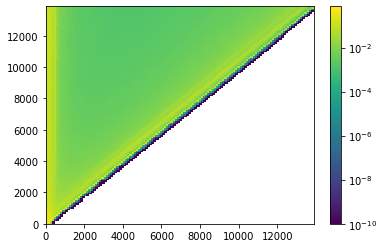

In [2]:
# Load a response matrix
#fname_resp_mat = "Dy164/data/response_matrix.m"
#fname_resp_mat = "response_matrix_OSCAR_Si28_compressed.m"
fname_resp_mat = "response_matrix_OSCAR_Si28_compressed.m"
R_mama = ompy.read_mama_2D(fname_resp_mat)

zmin_resp = 1e-10 # Plotting

print("Calibration coefficients:", R_mama.calibration())
print("E_max = ", R_mama.E0_array.max())

cbar = R_mama.plot(zscale="log", zmin=zmin_resp)
plt.colorbar(cbar)

<IPython.core.display.Javascript object>


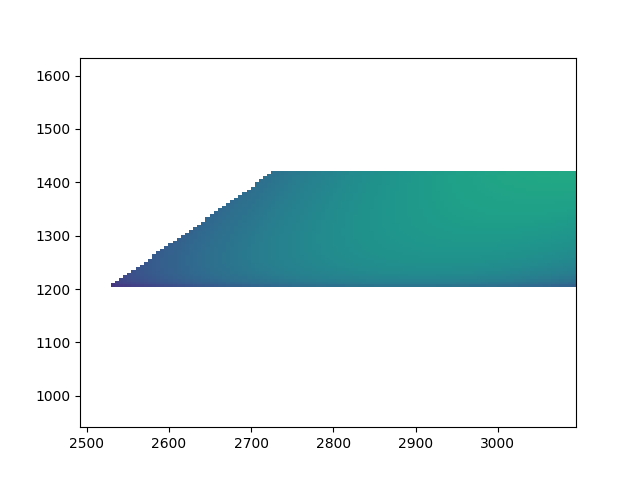

In [16]:
# Then do the same using OMpy functionality:

folderpath = "/home/jorgenem/gitrepos/ompy/oscar2017_scale1.15"
# TODO port to old NaI: I wrote the original code for Fabio's OSCAR responses. But we need to be able to use the old NaI response functions also.
#folderpath = "/home/jorgenem/gitrepos/oslo-method-software/mama/resp/nai2012"

# Energy calibration of resulting response matrix:
#Eout_array = ompy.E_array_from_calibration(a0=0.525000E+02-112/2, a1=0.112000E+03, E_max=13000)
Eout_array = ompy.E_array_from_calibration(a0=400, a1=5, E_max=3100)

# Experimental relative FWHM at 1.33 MeV of resulting array (TODO set up default value for this):
FWHM = 15 # I think this is the standard in MAMA, TODO double check

#%snakeviz R_ompy, f_FWHM_rel, f_Eff_tot, f_pcmp, f_pFE, f_pSE, f_pDE, f_p511 = ompy.interpolate_response(folderpath, Eout_array, FWHM)
R_ompy, f_FWHM_rel, f_Eff_tot, f_pcmp, f_pFE, f_pSE, f_pDE, f_p511 = ompy.interpolate_response(folderpath, Eout_array, FWHM)

#R_ompy = ompy.Matrix(matrix=R_ompy, E0_array=Eout_array, E1_array=Eout_array)
R_ompy.plot(zscale="log", zmin=zmin_resp)

<IPython.core.display.Javascript object>


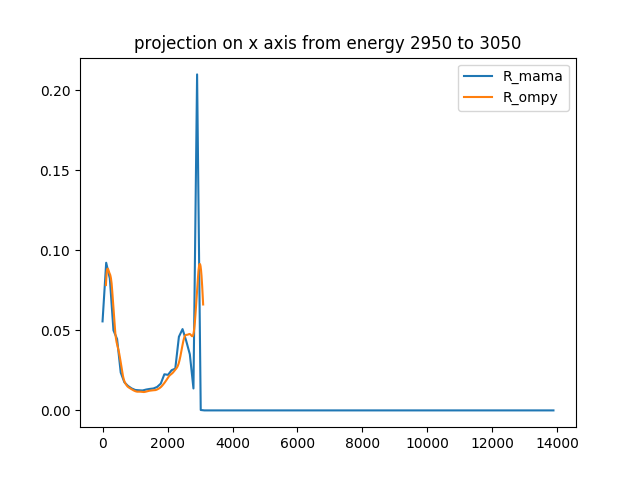

In [11]:
# Compare projections:
%matplotlib notebook

E_limits = [2950, 3050]

f, ax = plt.subplots(1)

# MAMA:
R_mama.plot_projection_x(E_limits = E_limits, ax=ax, label="R_mama")

# ompy:
R_ompy.plot_projection_x(E_limits = E_limits, ax=ax, label="R_ompy")

ax.legend()
ax.set_title("projection on x axis from energy {:d} to {:d}".format(
    E_limits[0], E_limits[1]))

plt.show()


## Test gauss smoothing function:

<IPython.core.display.Javascript object>


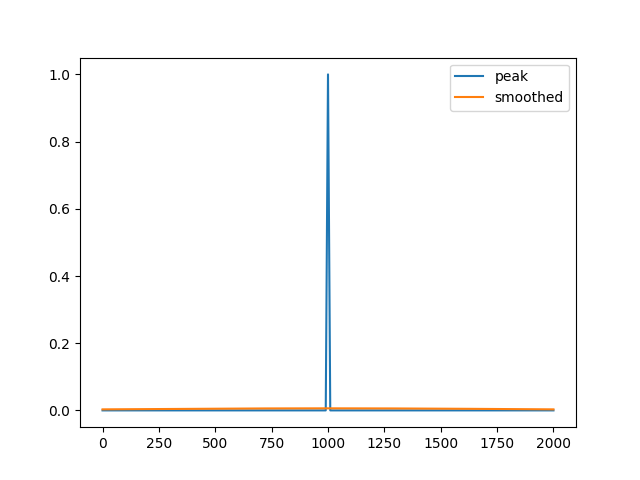

sum(counts_array) =  1.0
sum(counts_array_smoothed) =  1.0000000000000002


In [5]:

E_array = np.linspace(0, 2000, 201)
counts_array = np.zeros(len(E_array))
counts_array[100] = 1
FWHM_array = 200*np.ones(len(E_array))
#%snakeviz counts_array_smoothed = ompy.gauss_smoothing(counts_array, E_array, FWHM_array)
counts_array_smoothed = ompy.gauss_smoothing(counts_array, E_array, FWHM_array)

f, ax = plt.subplots(1)
ax.plot(E_array, counts_array, label="peak")
ax.plot(E_array, counts_array_smoothed, label="smoothed")

#ax.plot(E_array, 10*ompy.gaussian(E_array, E_array[100], 200/2.3), label="gaussian")

ax.legend()

print("sum(counts_array) = ", counts_array.sum())
print("sum(counts_array_smoothed) = ", counts_array_smoothed.sum())

In [6]:
dir(ompy)

['DE_GAMMA_1MEV',
 'DE_GAMMA_8MEV',
 'DE_PARTICLE',
 'DTYPE',
 'E_array_from_calibration',
 'E_compton',
 'EffExp',
 'ErrorPropagation',
 'FOLDER_PATH_RESPONSE_OSCAR',
 'FWHM_1332KEV_OSCAR',
 'FitRhoT',
 'LogNorm',
 'Matrix',
 'MatrixAnalysis',
 'PfromRhoT',
 'RectBivariateSpline',
 'SpinFunctions',
 'Unfolder',
 'Vector',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'call_model',
 'chi2',
 'compton_subtraction_method',
 'constants',
 'copy',
 'corr',
 'cut_diagonal',
 'decompose_matrix',
 'decompose_matrix_with_unc',
 'div0',
 'error_propagation',
 'fg_cut_matrix',
 'fill_negative',
 'first_generation_method',
 'fit_rho_T',
 'fluctuations',
 'gauss_smoothing',
 'gauss_smoothing_matrix',
 'gaussian',
 'i_from_E',
 'interp1d',
 'interpolate_matrix_1D',
 'interpolate_matrix_2D',
 'interpolate_response',
 'library',
 'line',
 'make_mask',
 'matrix_analysis',
 'minimize',
 'normalize',
 'np',
 'objfun1D',
 '

###### 